In [ ]:
# imports & config

import numpy as np
import matplotlib.pyplot as plt

from FNN import FNN
from TrainingFunctions import backwards
from ActivFunctions import sigmoid, identity
from LossFunctions import SoftmaxCrossEntropy, SoftmaxCrossEntropyDerivative
from gradient_descent import train_sgd, train_minibatch_sgd

# paths 
TRAIN_CSV_PATH = "fashion-mnist_train.csv"
TEST_CSV_PATH  = "fashion-mnist_test.csv"

NUM_CLASSES   = 10
HIDDEN_UNITS  = 256
EPOCHS        = 10          
LEARNING_RATE = 0.005
RANDOM_SEED   = 42

# to make runs faster while developing
MAX_TRAIN_SAMPLES = None   # or None to use all
MAX_TEST_SAMPLES  = None    # or None to use all

np.random.seed(RANDOM_SEED)
%matplotlib inline


In [2]:
# oad & preprocess Fashion-MNIST

def one_hot(labels, num_classes):
    labels = labels.astype(int)
    return np.eye(num_classes)[labels].T   # (num_classes, n_samples)


def load_fashion_mnist(train_path, test_path):
    # CSV format
    train_data = np.loadtxt(train_path, delimiter=",", skiprows=1)
    test_data  = np.loadtxt(test_path,  delimiter=",", skiprows=1)

    y_train = train_data[:, 0]
    X_train = train_data[:, 1:]
    y_test  = test_data[:, 0]
    X_test  = test_data[:, 1:]

    # normalize to [0,1]
    X_train = (X_train / 255.0).astype(np.float64)
    X_test  = (X_test  / 255.0).astype(np.float64)

    return X_train, y_train, X_test, y_test


X_train_raw, y_train, X_test_raw, y_test = load_fashion_mnist(
    TRAIN_CSV_PATH, TEST_CSV_PATH
)

# optional subsampling
if MAX_TRAIN_SAMPLES is not None:
    X_train_raw = X_train_raw[:MAX_TRAIN_SAMPLES]
    y_train     = y_train[:MAX_TRAIN_SAMPLES]

if MAX_TEST_SAMPLES is not None:
    X_test_raw = X_test_raw[:MAX_TEST_SAMPLES]
    y_test     = y_test[:MAX_TEST_SAMPLES]

# transpose so shape is (features, samples)
X_train = X_train_raw.T   # (784, n_train)
X_test  = X_test_raw.T    # (784, n_test)

Y_train = one_hot(y_train, NUM_CLASSES)   # (10, n_train)
Y_test  = one_hot(y_test,  NUM_CLASSES)   # (10, n_test)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test :", X_test.shape)
print("Y_test :", Y_test.shape)


X_train: (784, 60000)
Y_train: (10, 60000)
X_test : (784, 10000)
Y_test : (10, 10000)


In [3]:
# helper functions

#  Run one sample (as a column vector) through the network. Returns the final layer activations, which are raw 'logits'.
# (Softmax is applied inside the loss function.)

def forward_single(net, x_col):
    """
    Forward pass for a single sample.
    x_col shape: (features, 1)
    Returns logits (last layer pre-softmax scores).
    """
    z_vals, a_vals = net.forward(x_col)
    logits = a_vals[-1]   # last layer uses identity, so a[-1] = logits
    return logits


# Compute accuracy by checking how many predictions match the true labels.

def accuracy(net, X, Y_one_hot):
    n = X.shape[1]
    correct = 0
    for i in range(n):
        x_i = X[:, i:i+1]
        logits = forward_single(net, x_i)
        pred = int(np.argmax(logits))
        true = int(np.argmax(Y_one_hot[:, i]))
        if pred == true:
            correct += 1
    return correct / n

# Compute average softmax cross-entropy over all samples
def cross_entropy_loss(net, X, Y_one_hot):
    n = X.shape[1]
    total = 0.0
    for i in range(n):
        x_i = X[:, i:i+1]
        y_i = Y_one_hot[:, i:i+1]
        z_vals, a_vals = net.forward(x_i)
        logits = a_vals[-1]   # last layer = logits
        total += SoftmaxCrossEntropy(y_i, logits)
    return total / n

# Build a confusion matrix. rows = true class, columns = predicted class
def confusion_matrix(net, X, true_labels, num_classes=10):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    n = X.shape[1]
    for i in range(n):
        x_i = X[:, i:i+1]
        logits = forward_single(net, x_i)
        pred = int(np.argmax(logits))
        true = int(true_labels[i])
        cm[true, pred] += 1
    return cm


In [4]:
# build the network

n_inputs  = X_train.shape[0]   # 784
n_outputs = Y_train.shape[0]   # 10

arch = np.array([n_inputs, HIDDEN_UNITS, n_outputs], dtype=int)

net = FNN(
    weights=arch,
    activ_functions=sigmoid,  #sigmoid in all layers
    method_ini="Random",
    datatype_weights="float64",
    random_lower_bound=-0.1,
    random_upper_bound=0.1,
)

# change the OUTPUT layer activation to identity
# so the output of the network is raw logits
net.activ_functions_list[-1] = [
    identity for _ in net.activ_functions_list[-1]
]
   
print("Architecture:", arch)


Architecture: [784 256  10]


In [ ]:
# training loop

train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    # one pass over the data using YOUR SGD implementation
    train_sgd(
        network=net,
        inputs=X_train,
        targets=Y_train,
        epochs=1,
        learning_rate=LEARNING_RATE,
        loss_derivative=SoftmaxCrossEntropyDerivative
    )

    tr_loss = cross_entropy_loss(net, X_train, Y_train)
    te_loss = cross_entropy_loss(net, X_test,  Y_test)
    tr_acc  = accuracy(net, X_train, Y_train)
    te_acc  = accuracy(net, X_test,  Y_test)

    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)

    print(f"train loss: {tr_loss:.4f}, acc: {tr_acc*100:.1f}%")
    print(f"test  loss: {te_loss:.4f}, acc: {te_acc*100:.1f}%")



Epoch 1/10
train loss: 0.6697, acc: 76.0%
test  loss: 0.6790, acc: 75.8%

Epoch 2/10
train loss: 0.6291, acc: 78.0%
test  loss: 0.6398, acc: 77.6%

Epoch 3/10
train loss: 0.5918, acc: 79.8%
test  loss: 0.6022, acc: 79.6%

Epoch 4/10
train loss: 0.5832, acc: 80.7%
test  loss: 0.5913, acc: 80.4%

Epoch 5/10


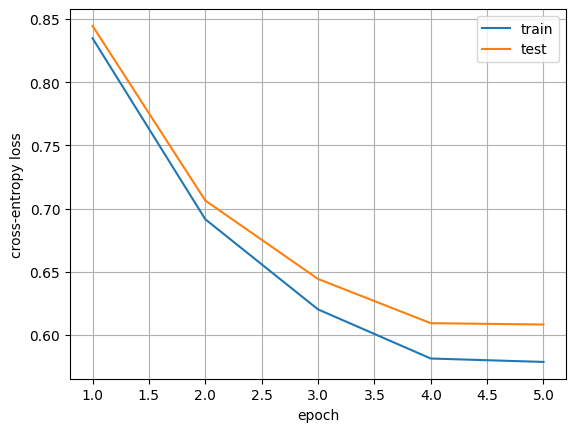

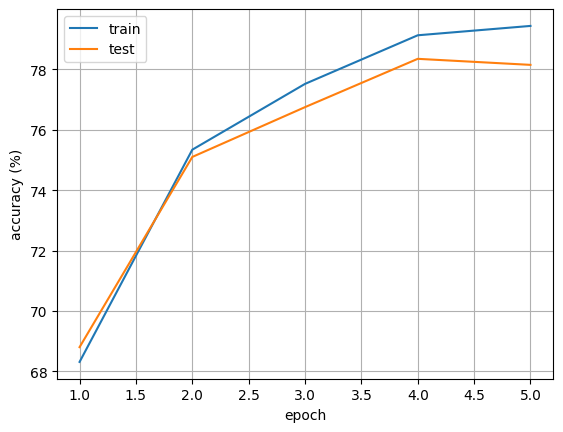

In [ ]:
# plots

epochs_arr = np.arange(1, EPOCHS + 1)

plt.figure()
plt.plot(epochs_arr, train_losses, label="train")
plt.plot(epochs_arr, test_losses,  label="test")
plt.xlabel("epoch")
plt.ylabel("cross-entropy loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs_arr, np.array(train_accs) * 100, label="train")
plt.plot(epochs_arr, np.array(test_accs)  * 100, label="test")
plt.xlabel("epoch")
plt.ylabel("accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


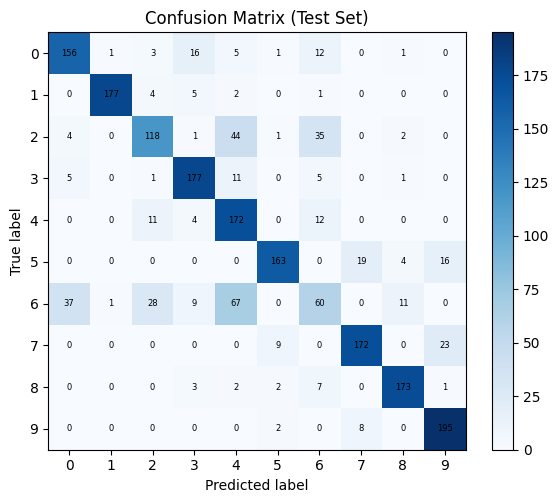

In [ ]:
# confusion matrix

cm = confusion_matrix(net, X_test, y_test, num_classes=NUM_CLASSES)

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.xticks(np.arange(NUM_CLASSES))
plt.yticks(np.arange(NUM_CLASSES))

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center", fontsize=6)

plt.tight_layout()
plt.show()


In [ ]:
# example predictions

num_examples = 10
print(f"\nExample predictions (first {num_examples} test samples):")
for i in range(num_examples):
    x_i = X_test[:, i:i+1]
    logits = forward_single(net, x_i)
    pred = int(np.argmax(logits))
    true = int(y_test[i])
    print(f"sample {i}: true={true}, pred={pred}")



Example predictions (first 10 test samples):
sample 0: true=0, pred=0
sample 1: true=1, pred=1
sample 2: true=2, pred=2
sample 3: true=2, pred=0
sample 4: true=3, pred=4
sample 5: true=2, pred=6
sample 6: true=8, pred=8
sample 7: true=6, pred=6
sample 8: true=5, pred=5
sample 9: true=0, pred=0
